In [1]:
import gym
import matplotlib.pyplot as plt
import ray
from ray import tune
from ray.rllib.agents.ppo import PPOTrainer
from navigation_gym.tasks.navigation_discrete_task import NavigationDiscreteTask

Instructions for updating:
non-resource variables are not supported in the long term


## Register Environment

In [2]:
env = gym.make('Navigation-v0')

print("Observation Space: {}".format(env.observation_space))
print("Action Space: {}".format(env.action_space))

/home/dschori/MasterThesis/ackerbot_sim_ws/src/rl-navigation/navigation_gym/src/navigation_gym/tasks/navigation_discrete_task.py:25: UserWarning: 'rl-navigation_42356_1615204664884' is not a legal ROS base name. This may cause problems with other ROS tools.
  rospy.init_node('rl-navigation', anonymous=True, log_level=rospy.INFO)
[ERROR] [1615204665.034579, 0.000000]: NOT Initialising Simulation Physics Parameters
[WARN] [1615204665.038017, 0.000000]: Start Init ControllersConnection
[WARN] [1615204665.038879, 0.000000]: END Init ControllersConnection


Observation Space: Box(0.0, 1.0, (84, 84, 4), float32)
Action Space: Discrete(3)


## Check Environment State

0.0
1.0


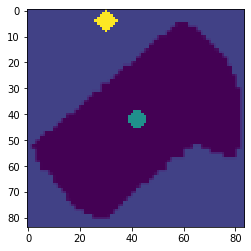

In [3]:
obs = env.reset()
for _ in range(4):
    obs, _, _, _ = env.step(action=2)
plt.imshow(obs[:, :, 0])
print(obs.min())
print(obs.max())

## Ray Configs

In [4]:
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import random
import gym
import pylab
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Lambda, Add, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import cv2

import threading
from threading import Thread, Lock
import time

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    print(f'GPUs {gpus}')
    try: tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError: pass


def OurModel(input_shape, action_space, lr):
    X_input = Input(input_shape)

    X = Conv2D(16, 8, strides=(4, 4),padding="valid", activation="elu", data_format="channels_first", input_shape=input_shape)(X_input)
    X = Conv2D(32, 4, strides=(2, 2),padding="valid", activation="elu", data_format="channels_first")(X)
    X = Conv2D(64, 3, strides=(1, 1),padding="valid", activation="elu", data_format="channels_first")(X)
    X = Flatten(input_shape=input_shape)(X_input)

    X = Dense(265, activation="elu", kernel_initializer='he_uniform')(X)
    #X = Dense(256, activation="elu", kernel_initializer='he_uniform')(X)
    #X = Dense(64, activation="elu", kernel_initializer='he_uniform')(X)

    action = Dense(action_space, activation="softmax", kernel_initializer='he_uniform')(X)
    value = Dense(1, activation='linear', kernel_initializer='he_uniform')(X)

    def ppo_loss(y_true, y_pred):
        # Defined in https://arxiv.org/abs/1707.06347
        advantages, prediction_picks, actions = y_true[:, :1], y_true[:, 1:1+action_space], y_true[:, 1+action_space:]
        LOSS_CLIPPING = 0.2
        ENTROPY_LOSS = 5e-3

        prob = y_pred * actions
        old_prob = actions * prediction_picks
        r = prob/(old_prob + 1e-10)
        p1 = r * advantages
        p2 = K.clip(r, min_value=1 - LOSS_CLIPPING, max_value=1 + LOSS_CLIPPING) * advantages
        loss =  -K.mean(K.minimum(p1, p2) + ENTROPY_LOSS * -(prob * K.log(prob + 1e-10)))

        return loss

    Actor = Model(inputs = X_input, outputs = action)
    Actor.compile(loss=ppo_loss, optimizer=RMSprop(lr=lr))

    Critic = Model(inputs = X_input, outputs = value)
    Critic.compile(loss='mse', optimizer=RMSprop(lr=lr))

    return Actor, Critic

class PPOAgent:
    # PPO Main Optimization Algorithm
    def __init__(self, env):
        # Initialization
        # Environment and PPO parameters
        self.env_name = 'Navigation-v0'
        self.env = env
        self.action_size = self.env.action_space.n
        self.EPISODES, self.episode, self.max_average = 1000, 0, -100.0 # specific for pong
        self.lock = Lock() # lock all to update parameters without other thread interruption
        self.lr = 0.0001

        self.ROWS = 84
        self.COLS = 84
        self.REM_STEP = 4
        self.EPOCHS = 10

        # Instantiate plot memory
        self.scores, self.episodes, self.average = [], [], []

        self.Save_Path = 'Models'
        self.state_size = (self.REM_STEP, self.ROWS, self.COLS)

        if not os.path.exists(self.Save_Path): os.makedirs(self.Save_Path)
        self.path = '{}_APPO_{}'.format(self.env_name, self.lr)
        self.Model_name = os.path.join(self.Save_Path, self.path)

        # Create Actor-Critic network model
        self.Actor, self.Critic = OurModel(input_shape=self.state_size, action_space = self.action_size, lr=self.lr)

    def act(self, state):
        # Use the network to predict the next action to take, using the model
        prediction = self.Actor.predict(state)[0]
        action = np.random.choice(self.action_size, p=prediction)
        return action, prediction

    def discount_rewards(self, reward):
        # Compute the gamma-discounted rewards over an episode
        gamma = 0.99    # discount rate
        running_add = 0
        discounted_r = np.zeros_like(reward)
        for i in reversed(range(0,len(reward))):
            if reward[i] != 0: # reset the sum, since this was a game boundary (pong specific!)
                running_add = 0
            running_add = running_add * gamma + reward[i]
            discounted_r[i] = running_add

        discounted_r -= np.mean(discounted_r) # normalizing the result
        discounted_r /= np.std(discounted_r) # divide by standard deviation
        return discounted_r

    def replay(self, states, actions, rewards, predictions):
        # reshape memory to appropriate shape for training
        states = np.vstack(states)
        actions = np.vstack(actions)
        predictions = np.vstack(predictions)

        # Compute discounted rewards
        discounted_r = np.vstack(self.discount_rewards(rewards))

        # Get Critic network predictions
        values = self.Critic.predict(states)
        # Compute advantages
        advantages = discounted_r - values

        '''
        pylab.plot(discounted_r,'-')
        pylab.plot(advantages,'.')
        ax=pylab.gca()
        ax.grid(True)
        pylab.show()
        '''
        # stack everything to numpy array
        y_true = np.hstack([advantages, predictions, actions])

        # training Actor and Critic networks
        self.Actor.fit(states, y_true, epochs=self.EPOCHS, verbose=0, shuffle=True, batch_size=len(rewards))
        self.Critic.fit(states, discounted_r, epochs=self.EPOCHS, verbose=0, shuffle=True, batch_size=len(rewards))

    def load(self, Actor_name, Critic_name):
        self.Actor = load_model(Actor_name, compile=False)
        #self.Critic = load_model(Critic_name, compile=False)

    def save(self):
        self.Actor.save(self.Model_name + '_Actor.h5')
        #self.Critic.save(self.Model_name + '_Critic.h5')

    pylab.figure(figsize=(18, 9))
    def PlotModel(self, score, episode):
        self.scores.append(score)
        self.episodes.append(episode)
        self.average.append(sum(self.scores[-50:]) / len(self.scores[-50:]))
        if str(episode)[-2:] == "00":# much faster than episode % 100
            pylab.plot(self.episodes, self.scores, 'b')
            pylab.plot(self.episodes, self.average, 'r')
            pylab.ylabel('Score', fontsize=18)
            pylab.xlabel('Steps', fontsize=18)
            try:
                pylab.savefig(self.path+".png")
            except OSError:
                pass

        return self.average[-1]

    def imshow(self, image, rem_step=0):
        cv2.imshow("cartpole"+str(rem_step), image[rem_step,...])
        if cv2.waitKey(25) & 0xFF == ord("q"):
            cv2.destroyAllWindows()
            return

    def GetImage(self, frame, image_memory):
        if image_memory.shape == (1,*self.state_size):
            image_memory = np.squeeze(image_memory)

        # croping frame to 80x80 size
        frame_cropped = frame[35:195:2, ::2,:]
        if frame_cropped.shape[0] != self.COLS or frame_cropped.shape[1] != self.ROWS:
            # OpenCV resize function
            frame_cropped = cv2.resize(frame, (self.COLS, self.ROWS), interpolation=cv2.INTER_CUBIC)

        # converting to RGB (numpy way)
        frame_rgb = 0.299*frame_cropped[:,:,0] + 0.587*frame_cropped[:,:,1] + 0.114*frame_cropped[:,:,2]

        # convert everything to black and white (agent will train faster)
        frame_rgb[frame_rgb < 100] = 0
        frame_rgb[frame_rgb >= 100] = 255
        # converting to RGB (OpenCV way)
        #frame_rgb = cv2.cvtColor(frame_cropped, cv2.COLOR_RGB2GRAY)

        # dividing by 255 we expresses value to 0-1 representation
        new_frame = np.array(frame_rgb).astype(np.float32) / 255.0

        # push our data by 1 frame, similar as deq() function work
        image_memory = np.roll(image_memory, 1, axis = 0)

        # inserting new frame to free space
        image_memory[0,:,:] = new_frame

        # show image frame
        #self.imshow(image_memory,0)
        #self.imshow(image_memory,1)
        #self.imshow(image_memory,2)
        #self.imshow(image_memory,3)

        return np.expand_dims(image_memory, axis=0)

    def reset(self, env):
        image_memory = np.zeros(self.state_size)
        frame = env.reset()
        for i in range(self.REM_STEP):
            state = self.GetImage(frame, image_memory)
        return state

    def step(self, action, env, image_memory):
        next_state, reward, done, info = env.step(action)
        next_state = self.GetImage(next_state, image_memory)
        return next_state, reward, done, info

    def run(self):
        for e in range(self.EPISODES):
            state = self.reset(self.env)
            done, score, SAVING = False, 0, ''
            # Instantiate or reset games memory
            states, actions, rewards, predictions = [], [], [], []
            while not done:
                #self.env.render()
                # Actor picks an action
                action, prediction = self.act(state)
                # Retrieve new state, reward, and whether the state is terminal
                next_state, reward, done, _ = self.step(action, self.env, state)
                # Memorize (state, action, reward) for training
                states.append(state)
                action_onehot = np.zeros([self.action_size])
                action_onehot[action] = 1
                actions.append(action_onehot)
                rewards.append(reward)
                predictions.append(prediction)
                # Update current state
                state = next_state
                score += reward
                if done:
                    average = self.PlotModel(score, e)
                    # saving best models
                    if average >= self.max_average:
                        self.max_average = average
                        self.save()
                        SAVING = "SAVING"
                    else:
                        SAVING = ""
                    print("episode: {}/{}, score: {}, average: {:.2f} {}".format(e, self.EPISODES, score, average, SAVING))

                    self.replay(states, actions, rewards, predictions)

        self.env.close()

    def train(self):
        while self.episode < self.EPISODES:
            # Reset episode
            score, done, SAVING = 0, False, ''
            state = self.reset(env)
            # Instantiate or reset games memory
            states, actions, rewards, predictions = [], [], [], []
            while not done:
                action, prediction = self.act(state)
                next_state, reward, done, _ = self.step(action, self.env, state)

                states.append(state)
                action_onehot = np.zeros([self.action_size])
                action_onehot[action] = 1
                actions.append(action_onehot)
                rewards.append(reward)
                predictions.append(prediction)

                score += reward
                state = next_state

            self.replay(states, actions, rewards, predictions)

            average = self.PlotModel(score, self.episode)
            # saving best models
            if average >= self.max_average:
                self.max_average = average
                self.save()
                SAVING = "SAVING"
            else:
                SAVING = ""
            print("episode: {}/{}, score: {}, average: {:.2f} {}".format(self.episode, self.EPISODES, score, average, SAVING))
            if(self.episode < self.EPISODES):
                self.episode += 1
        env.close()

    def test(self, Actor_name, Critic_name):
        self.load(Actor_name, Critic_name)
        for e in range(100):
            state = self.reset(self.env)
            done = False
            score = 0
            while not done:
                self.env.render()
                action = np.argmax(self.Actor.predict(state))
                state, reward, done, _ = self.step(action, self.env, state)
                score += reward
                if done:
                    print("episode: {}/{}, score: {}".format(e, self.EPISODES, score))
                    break

GPUs [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<Figure size 1296x648 with 0 Axes>

In [5]:
agent = PPOAgent(env)

episode: 0/1000, score: -109.42181735665659, average: -109.42 
episode: 1/1000, score: -108.87223345848932, average: -109.15 
episode: 2/1000, score: -108.40457257145177, average: -108.90 
episode: 3/1000, score: -105.58355223715208, average: -108.07 
episode: 4/1000, score: -108.29767976486828, average: -108.12 
episode: 5/1000, score: -90.75259496651005, average: -105.22 
episode: 6/1000, score: -121.85866512509024, average: -107.60 
episode: 7/1000, score: -105.98046913753103, average: -107.40 
episode: 8/1000, score: -107.17927060337178, average: -107.37 
episode: 9/1000, score: -107.27702955780188, average: -107.36 
episode: 10/1000, score: -109.75920997874033, average: -107.58 
episode: 11/1000, score: -91.73325897380367, average: -106.26 
episode: 12/1000, score: -108.19054403845902, average: -106.41 
episode: 13/1000, score: -109.10673070613717, average: -106.60 
episode: 14/1000, score: -90.5159281923346, average: -105.53 
episode: 15/1000, score: -106.5360468605548, average: 

/home/dschori/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


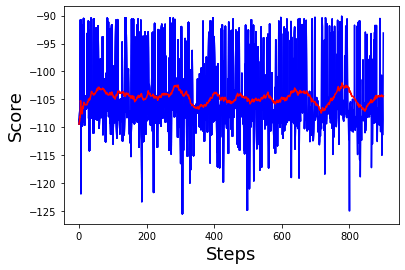

In [6]:
agent.train()